# Forest Cover Type Prediction

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565892 entries, 0 to 565891
Data columns (total 55 columns):
Id                                    565892 non-null int64
Elevation                             565892 non-null int64
Aspect                                565892 non-null int64
Slope                                 565892 non-null int64
Horizontal_Distance_To_Hydrology      565892 non-null int64
Vertical_Distance_To_Hydrology        565892 non-null int64
Horizontal_Distance_To_Roadways       565892 non-null int64
Hillshade_9am                         565892 non-null int64
Hillshade_Noon                        565892 non-null int64
Hillshade_3pm                         565892 non-null int64
Horizontal_Distance_To_Fire_Points    565892 non-null int64
Wilderness_Area1                      565892 non-null int64
Wilderness_Area2                      565892 non-null int64
Wilderness_Area3                      565892 non-null int64
Wilderness_Area4                      565892 non-

1. Test data is much bigger than train data
2. There is no missing value

In [6]:
# split train data into train & validation data
dataset = [train, test]
for data in dataset:
    data.drop('Id', axis=1, inplace=True)

x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

nb_classes = y_train.max()
training_samples = x_train.shape[0]

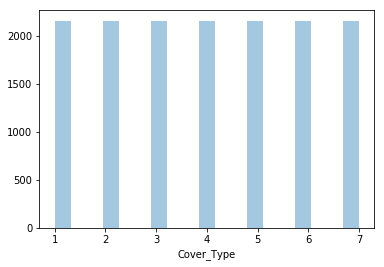

In [7]:
sns.distplot(y_train, kde=False)
# the numbers of labels are same

In [8]:
# numbers of quantative features
nb_quantative = 10
quantative = list(train.columns[:nb_quantative])
qualitative = list(train.columns[nb_quantative:])

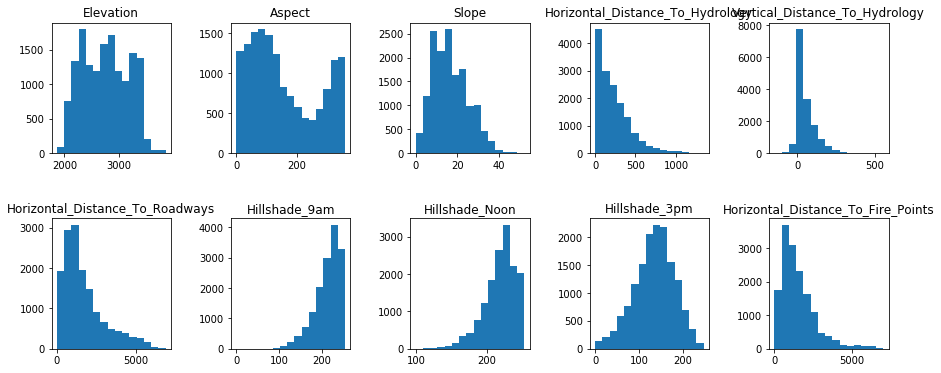

In [9]:
fig, axis = plt.subplots(2,5, figsize=(15,6))
fig.subplots_adjust(hspace = .5, wspace=0.5)
axis = axis.ravel()

for idx, col in enumerate(quantative):
    axis[idx].hist(x=train[col], bins=15)
    axis[idx].set_title(col)

Elevation, Slope, Hillshade_3pm : Gaussian distribution
Some Horizontal Distance features are quadratic
Vertical Distance To Hydrology values can be negative

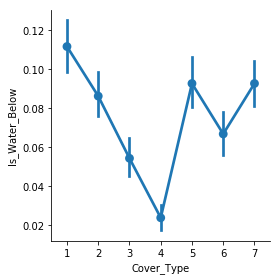

In [10]:
# new feature : Is hydrology below the forest?
for data in dataset:
    data['Is_Water_Below'] = data.apply(
        lambda x: 1 if x['Vertical_Distance_To_Hydrology'] < 0 else 0, axis=1)
sns.factorplot(x='Cover_Type',y='Is_Water_Below',data=train)

In [11]:
# new feature : distance to hydrology
for data in dataset:
    data['Distance_To_Hydrology'] = np.sqrt(data['Horizontal_Distance_To_Hydrology']**2
                            + data['Vertical_Distance_To_Hydrology']**2)

In [12]:
# new feature : sum of two distance factors and absolute difference
for data in dataset:
    data['Elev_Horz_Hydro_Sum'] = data['Elevation'] + data['Horizontal_Distance_To_Hydrology']
    data['Elev_Horz_Hydro_Diff'] = np.abs(data['Elevation'] - data['Horizontal_Distance_To_Hydrology'])
    data['Elev_Vert_Hydro_Sum'] = data['Elevation'] + data['Vertical_Distance_To_Hydrology']
    data['Elev_Vert_Hydro_Diff'] = np.abs(data['Elevation'] - data['Vertical_Distance_To_Hydrology'])
    
    data['Fire_Road_Sum'] = data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Roadways']
    data['Fire_Road_Diff'] = np.abs(data['Horizontal_Distance_To_Fire_Points'] -
                                    data['Horizontal_Distance_To_Roadways'])
    
    data['Hydro_Road_Sum'] = data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Roadways']
    data['Hydro_Road_Diff'] = np.abs(data['Horizontal_Distance_To_Hydrology'] -
                                     data['Horizontal_Distance_To_Roadways'])
    
    data['Hydro_Fire_Sum'] = data['Horizontal_Distance_To_Hydrology'] + \
                             data['Horizontal_Distance_To_Fire_Points']
    data['Hydro_Fire_Diff'] = np.abs(data['Horizontal_Distance_To_Hydrology'] - \
                                     data['Horizontal_Distance_To_Fire_Points'])

In [13]:
# feature processing : sqrt of quadratic features
quadratic_features = ['Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                      'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points',
                    'Distance_To_Hydrology', 'Fire_Road_Sum', 'Fire_Road_Diff',
                      'Hydro_Road_Sum', 'Hydro_Fire_Sum', 'Hydro_Fire_Diff']
for col in quadratic_features:
    for data in dataset:
        data[col] = np.sqrt(data[col])

In [14]:
ref_index = list(train.columns).index('Distance_To_Hydrology')
new_quantative = list(train.columns[ref_index:])
quantative += new_quantative

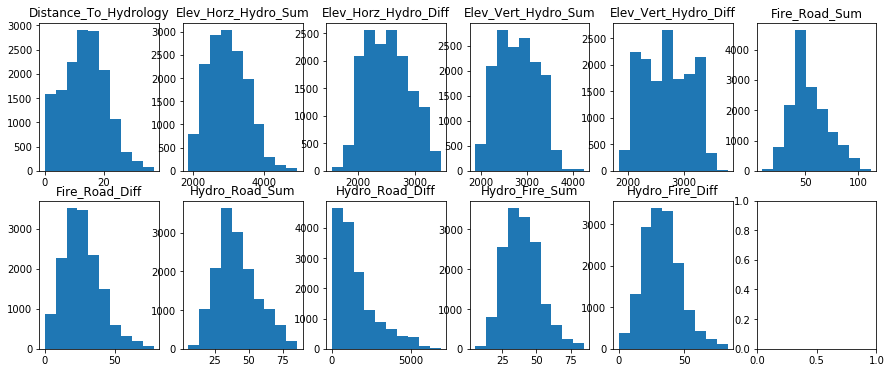

In [15]:
fig, axis = plt.subplots(2, 6, figsize=(15,6))
axis = axis.ravel()
for idx, col in enumerate(new_quantative):
    axis[idx].hist(train[col])
    axis[idx].set_title(col)

In [16]:
# drop the constant columns
cols_constant = [col for col in train.columns if train[col].std() == 0]
for data in dataset:
    if cols_constant != 'Cover_Type':
        data.drop(cols_constant, axis=1, inplace=True)

In [17]:
train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type', 'Is_Water_Be

In [18]:
# Standardization
# sc = StandardScaler()
# sc.fit(train[quantative])
# for data in dataset:
#     data[quantative] = sc.transform(data[quantative])

In [19]:
y_train = train.loc[:, 'Cover_Type']
x_train = train.drop('Cover_Type', axis=1)

# Models

In [20]:
x_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Elev_Horz_Hydro_Sum,Elev_Horz_Hydro_Diff,Elev_Vert_Hydro_Sum,Elev_Vert_Hydro_Diff,Fire_Road_Sum,Fire_Road_Diff,Hydro_Road_Sum,Hydro_Road_Diff,Hydro_Fire_Sum,Hydro_Fire_Diff
0,2596,51,3,16.062378,0,22.583180,14.866069,15.231546,148,79.240141,...,2854,2338,2596,2596,82.395388,75.953933,27.712813,252,80.851716,77.595103
1,2590,56,2,14.560220,-6,19.748418,14.832397,15.329710,151,78.898669,...,2802,2378,2584,2596,81.332650,76.387172,24.535688,178,80.230917,77.543536
2,2804,139,9,16.370706,65,56.391489,15.297059,15.427249,135,78.236820,...,3072,2536,2869,2739,96.441692,54.230987,58.719673,2912,79.931220,76.504902
3,2785,155,18,15.556349,118,55.587768,15.427249,15.427249,122,78.809898,...,3027,2543,2903,2667,96.441692,55.865911,57.723479,2848,80.330567,77.259304
4,2595,45,2,12.369317,-1,19.773720,14.832397,15.297059,150,78.562077,...,2748,2442,2594,2596,81.012345,76.032888,23.323808,238,79.529869,77.582214


In [21]:
# Logistic Regression
lr = LogisticRegression(C=10)
lr.fit(x_train, y_train)
lr_pred = lr.predict(test)
lr.score(x_train, y_train)

0.68386243386243384

In [22]:
# Raondom Forest
rf = RandomForestClassifier(n_estimators=300,max_depth=7)
rf.fit(x_train, y_train)
rf.score(x_train, y_train)

0.78928571428571426

In [23]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [24]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
knn.score(x_train, y_train)
# knn_pred = knn.predict(x_test)

0.89841269841269844

In [25]:
# Support Vector Machine
svc = SVC()
svc.fit(x_train, y_train)
svc.score(x_train, y_train)
# svc_pred = svc.predict(x_test)

1.0

In [31]:
for estimator in [rf, knn]:
    scores = cross_val_score(estimator = estimator,
                         X = x_train,
                         y = y_train, 
                         cv = 10,
                         n_jobs = -1
                        )

    print('CV accuracy of %s is \n %.3f +-%.3f' %(str(estimator), np.mean(scores), np.std(scores)))

CV accuracy of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) is 
 0.719 +-0.034
CV accuracy of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') is 
 0.686 +-0.044


In [32]:
# xgbclassifier
clf = xgb.XGBClassifier(max_depth=7,
                        n_estimators=350, learning_rate=0.03,
                        subsample=0.95,
                        colsample_bytree=0.85, seed=1)

In [35]:
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size=0.2)

In [36]:
# fitting
clf.fit(train_x, train_y,
        early_stopping_rounds=40, 
        eval_metric="merror", eval_set=[(val_x, val_y)])

[0]	validation_0-merror:0.252976
Will train until validation_0-merror hasn't improved in 40 rounds.
[1]	validation_0-merror:0.225198
[2]	validation_0-merror:0.218915
[3]	validation_0-merror:0.219907
[4]	validation_0-merror:0.221892
[5]	validation_0-merror:0.217262
[6]	validation_0-merror:0.214286
[7]	validation_0-merror:0.209656
[8]	validation_0-merror:0.207341
[9]	validation_0-merror:0.203042
[10]	validation_0-merror:0.207011
[11]	validation_0-merror:0.204034
[12]	validation_0-merror:0.204365
[13]	validation_0-merror:0.205357
[14]	validation_0-merror:0.204365
[15]	validation_0-merror:0.204034
[16]	validation_0-merror:0.203373
[17]	validation_0-merror:0.204365
[18]	validation_0-merror:0.201058
[19]	validation_0-merror:0.199405
[20]	validation_0-merror:0.198743
[21]	validation_0-merror:0.196429
[22]	validation_0-merror:0.195437
[23]	validation_0-merror:0.195767
[24]	validation_0-merror:0.194444
[25]	validation_0-merror:0.195437
[26]	validation_0-merror:0.193783
[27]	validation_0-merror:

[236]	validation_0-merror:0.152778
[237]	validation_0-merror:0.153108
[238]	validation_0-merror:0.152778
[239]	validation_0-merror:0.152447
[240]	validation_0-merror:0.152778
[241]	validation_0-merror:0.152447
[242]	validation_0-merror:0.152447
[243]	validation_0-merror:0.152447
[244]	validation_0-merror:0.152447
[245]	validation_0-merror:0.152447
[246]	validation_0-merror:0.151786
[247]	validation_0-merror:0.152116
[248]	validation_0-merror:0.152116
[249]	validation_0-merror:0.152447
[250]	validation_0-merror:0.152116
[251]	validation_0-merror:0.152116
[252]	validation_0-merror:0.152116
[253]	validation_0-merror:0.151455
[254]	validation_0-merror:0.151124
[255]	validation_0-merror:0.150132
[256]	validation_0-merror:0.14914
[257]	validation_0-merror:0.14914
[258]	validation_0-merror:0.14881
[259]	validation_0-merror:0.14914
[260]	validation_0-merror:0.14881
[261]	validation_0-merror:0.149471
[262]	validation_0-merror:0.149471
[263]	validation_0-merror:0.149471
[264]	validation_0-merror

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.85,
       gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=350, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=0.95)

In [37]:
clf.score(val_x, val_y)

0.85912698412698407

In [39]:
clf_pred = clf.predict(test)

# Submission

In [40]:
prediction = clf_pred

In [41]:
submission = pd.DataFrame({
        'Id': np.arange(train.shape[0]+1, train.shape[0]+prediction.shape[0]+1),
        'Cover_Type': prediction
})
cols = submission.columns 
cols = cols[::-1]
submission = submission[cols]
submission.to_csv('submission/submission_clf.csv', index=False)